<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Начнем работу с импорта необходимых для работы библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

Откроем датасет, выведем первые несколько строк датасета, а также выведем информацию о нем

In [2]:
data = pd.read_csv('/datasets/taxi.csv')
display(data.head(10))
data.info()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Как мы видим пропуски отсутствуют. Поменяем формат времени в столбце 'datetime' с object на datetime64 и установим индекс таблицы равным столбцу 'datetime'

In [3]:
data['datetime'] = data['datetime'].astype('datetime64')

In [4]:
data = data.set_index('datetime')

Проверим, в хронологическом ли порядке расположены даты и время

In [5]:
data = data.sort_index(ascending=True)
print(data.index.is_monotonic)

True


Данные расположены в хронологическом порядке. Выполним ресемплирование по одному часу и посчитаем суммы заказов за каждый час

In [6]:
data = data.resample('1H').sum()
display(data.head(10))

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Построим график временного ряда

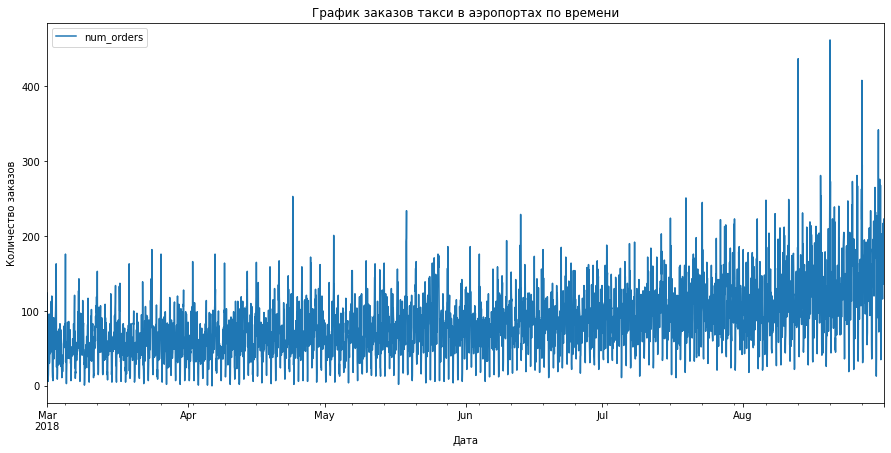

In [7]:
plt.figure(figsize=(15, 7))
data.plot(ax=plt.gca())
plt.title('График заказов такси в аэропортах по времени')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.show()

<b>Вывод: </b> Мы оценили исходный датасет, узнали его размер, поменяли формат необходимых столбцов, оценили пропуски, проверили хронологический ли у нас порядок, выполнили ресемплирование и построили график временного ряда

## Анализ

Чтобы лучше понимать временной ряд оценим тренды и сезонность в нем, а также построим графики составляющих нашего временного ряда

In [8]:
decomposed = seasonal_decompose(data)

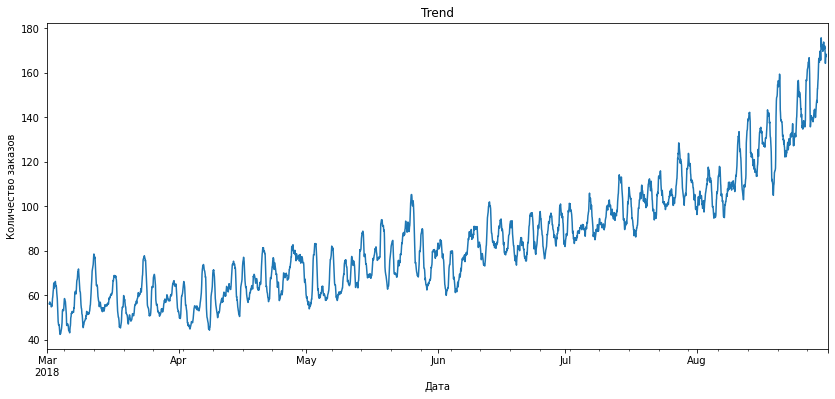

In [9]:
plt.figure(figsize=(14, 6))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.show()

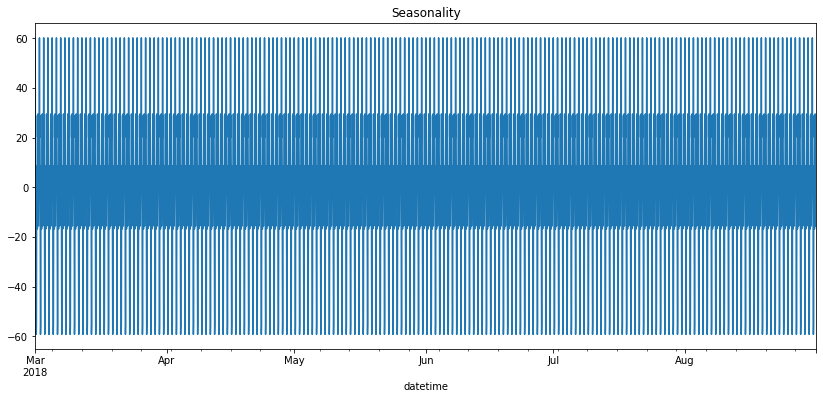

In [10]:
plt.figure(figsize=(14, 6))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.show()

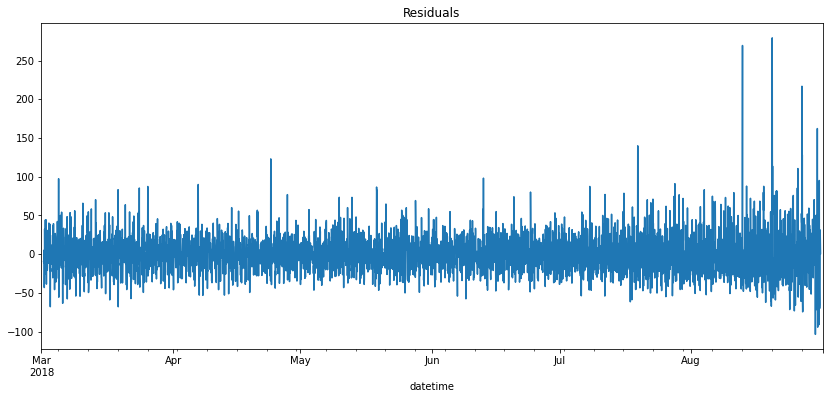

In [11]:
plt.figure(figsize=(14, 6))
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.show()

Как мы видим трендом является постепенный рост заказов за все время наблюдения

Чтобы сделать какие-то выводы о сезонности рассмотрим отрезок в 5 дней и 2 дня в рандомном месте нашего временного ряда

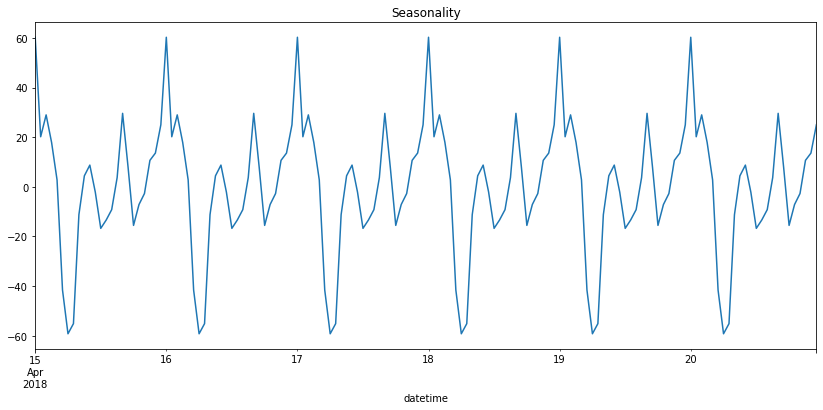

In [12]:
plt.figure(figsize=(14, 6))
decomposed.seasonal['2018-04-15':'2018-04-20'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.show()

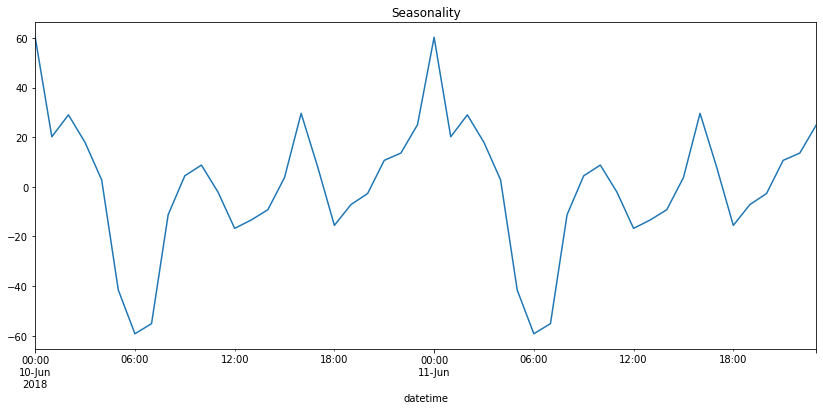

In [13]:
plt.figure(figsize=(14, 6))
decomposed.seasonal['2018-06-10':'2018-06-11'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.show()

Как мы видим наибольшее количество заказов наблюдается в районе 00:00, наименьшее в районе 06:00 

Перед тем как заниматься обучением моделей нам необходимо создать признаки для прогнозирования и сделать разделение датасета на выборки.
Начнем с создания функции побавляющей признаки следующих типов:
- календарные признаки (представим дату, день недели и время как отдельные столбцы)
- "отстающие" значения (предыдущие значения временного ряда подскажут, будет ли наша функция расти или уменьшаться)
- скользящее среднее (задаёт общий тренд временного ряда)

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Выбираем значения аргументов исходя из сезонности (в дальнейшем мы можем менять их для изменения качества)

In [15]:
make_features(data, 77, 24)

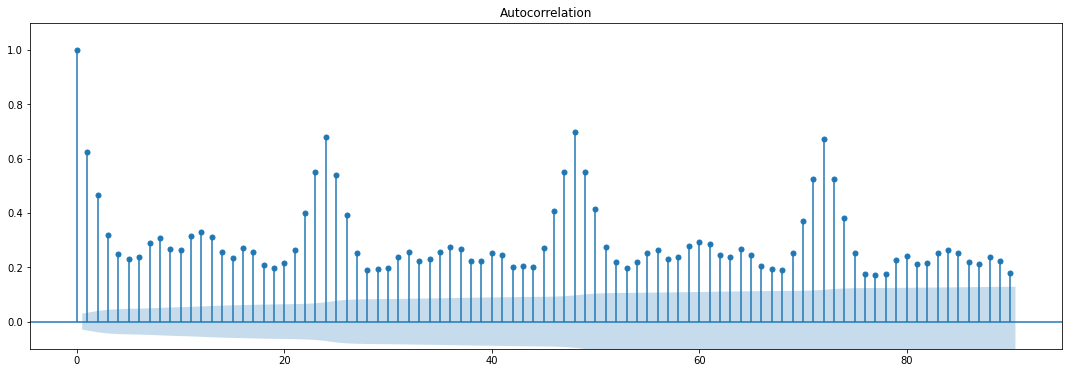

In [16]:
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(data['num_orders'],lags= 90)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

Далее разобьем данные на выборки: выделим 10% данных для тестовой выборки, остальные 90% — для обучающей и валидационной. А также из обучающей и валидационной выборки удалим строки с пропусками.

In [17]:
data_train_valid, data_test = train_test_split(data, test_size=0.1, shuffle=False, random_state=12345)
data_train_valid = data_train_valid.dropna()

Далее из обучающей и валидационной выборок выделим каждую из них по отдельности. На валидационную выделим 25%, а на обучающую 75%

In [18]:
data_train, data_valid = train_test_split(data_train_valid, test_size=0.25, shuffle=False, random_state=12345)

Целевым признаком в нашем датасете является столбец "num_orders" - именно в нем содержится информацию о количестве заказов и его нам необходимо будет предсказывать. Остальные столбцы датасета будут признаками. Создадим переменные для признаков и целевого признака для каждой выборки

In [19]:
features_train = data_train.drop(['num_orders'], axis=1)
target_train = data_train['num_orders']
features_valid = data_valid.drop(['num_orders'], axis=1)
target_valid = data_valid['num_orders']
features_test = data_test.drop(['num_orders'], axis=1)
target_test = data_test['num_orders']

Выведем размеры получившихся выборок, чтобы удостовериться, что мы сделали правильное разбиение

In [20]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(2922, 81)
(2922,)
(975, 81)
(975,)
(442, 81)
(442,)


Как мы видим необходимые пропорции при разделении датасетов на выборки получены - теперь можно обучать модель

<b>Вывод: </b> мы проанализировали исходный датасет, оценили тренды и сезонность в нем, построили соответствующие графики, создали признаки для прогнозирования и сделали разделение датасета на выборки.

## Обучение

Применим модель "Линейная регрессия" и вычислим RMSE

In [21]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
mse = mean_squared_error(target_valid, predictions)
rmse = mse ** 0.5
print('RMSE Линейной регрессии:', rmse)

RMSE Линейной регрессии: 28.978168128310607


Применим модель "Дерево решений": подберем наилучшие параметры и вычислим RMSE

In [22]:
best_model = None
best_rmse = 100
for i in range(2, 15):
    for j in range(2,15):
            model = DecisionTreeClassifier(random_state=12345, max_depth=i, min_samples_leaf=j)
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            mse = mean_squared_error(target_valid, predictions)
            rmse = mse ** 0.5
            if rmse < best_rmse:
                best_model = model
                best_rmse = rmse
print("Параметры наилучшей модели:", best_model)
print("RMSE лучшей модели 'Дерево решений':", best_rmse)

Параметры наилучшей модели: DecisionTreeClassifier(max_depth=7, min_samples_leaf=6, random_state=12345)
RMSE лучшей модели 'Дерево решений': 37.90066639019046


Применим модель "Случайный лес": подберем наилучшие параметры и вычислим RMSE

In [23]:
best_model = None
best_rmse = 100
for i in range(10, 50, 10):
    for j in range(2, 10):
            model = RandomForestRegressor(random_state=12345, n_estimators=i, max_depth=j)
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            mse = mean_squared_error(target_valid, predictions)
            rmse = mse ** 0.5
            if rmse < best_rmse:
                best_model = model
                best_rmse = rmse
print("Параметры наилучшей модели:", best_model)
print("RMSE лучшей модели 'Дерево решений':", best_rmse)

Параметры наилучшей модели: RandomForestRegressor(max_depth=9, n_estimators=40, random_state=12345)
RMSE лучшей модели 'Дерево решений': 30.02405402066251


Применим модель "CatBoost"

In [24]:
model =  CatBoostRegressor(iterations=300)
model.fit(features_train, target_train, verbose=30)
predictions = model.predict(features_valid)
mse = mean_squared_error(target_valid, predictions)
rmse = mse ** 0.5
print('RMSE модели "CatBoost":', rmse)

Learning rate set to 0.12908
0:	learn: 31.7988000	total: 66.5ms	remaining: 19.9s
30:	learn: 18.9835300	total: 500ms	remaining: 4.34s
60:	learn: 17.1437543	total: 928ms	remaining: 3.64s
90:	learn: 15.5418383	total: 1.34s	remaining: 3.08s
120:	learn: 14.1935002	total: 1.78s	remaining: 2.64s
150:	learn: 13.0713456	total: 2.22s	remaining: 2.19s
180:	learn: 12.1263961	total: 2.64s	remaining: 1.74s
210:	learn: 11.1785348	total: 3.09s	remaining: 1.3s
240:	learn: 10.3238392	total: 3.53s	remaining: 864ms
270:	learn: 9.6551882	total: 4s	remaining: 428ms
299:	learn: 9.0084136	total: 4.42s	remaining: 0us
RMSE модели "CatBoost": 29.84477723174986


<b>Вывод: </b> Нами было использовано 4 модели:
- все модели обеспечили требуемое нам значение RMSE (<48);
- наилучшее значение метрики RMSE показала модель "CatBoost" и "Линейная регрессия", далее "Случайный лес", выполняющийся дольше

Проанализировав вышесказанное, мы можем прийти к выводу, что нам наиболее подойдет модель "CatBoost" - ее мы и будем использовать для тестовой выборки

## Тестирование

Проверим нашу наилучшую модель на тестовой выборке. Перед этим объединим обучающую и валидационную выборки для обучения нашей модели

In [25]:
features_tr_vl = pd.concat([features_train, features_valid])
target_tr_vl = pd.concat([target_train, target_valid])

Проведем проверку нашей модели 'CatBoost'

In [26]:
model =  CatBoostRegressor(iterations=300)
model.fit(features_tr_vl, target_tr_vl, verbose=30)
predictions = model.predict(features_test)
mse = mean_squared_error(target_test, predictions)
rmse = mse ** 0.5
print('RMSE модели "CatBoost":', rmse)

Learning rate set to 0.135088
0:	learn: 36.2077023	total: 23.5ms	remaining: 7.03s
30:	learn: 21.2750076	total: 527ms	remaining: 4.57s
60:	learn: 19.5825997	total: 1.03s	remaining: 4.04s
90:	learn: 17.7872979	total: 1.56s	remaining: 3.58s
120:	learn: 16.5444921	total: 2.05s	remaining: 3.04s
150:	learn: 15.4276921	total: 2.54s	remaining: 2.51s
180:	learn: 14.3975102	total: 3.04s	remaining: 2s
210:	learn: 13.4315998	total: 3.55s	remaining: 1.5s
240:	learn: 12.5721230	total: 4.07s	remaining: 997ms
270:	learn: 11.7883252	total: 4.6s	remaining: 493ms
299:	learn: 11.0948002	total: 5.11s	remaining: 0us
RMSE модели "CatBoost": 38.269749822533356


Как мы видим нам удалось достичь требуемого значения RMSE для модели 'CatBoost' на тестовой выборке.

<b>Вывод: </b> нами был обработан исходный датасет, выполнено ресемплирование и проанализированы признаки, оценены тренды и сезонность, подготовлено и протестировано несколько моделей. Выбрав модель 'CatBoost', показавшую наилучшее значение RMSE на валидационной выборке и проверив ее на тестовой выборке нам удалось достичь требуемого значения RMSE. Таким образом наша модель сможет спрогнозировать количество заказов такси в аэропортах для привлечения необходимого числа водителей